In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import imageio.v2 as imageio
import cv2
import os
import PIL
import random
import SimpleITK as sitk
from albumentations.pytorch import ToTensorV2
import albumentations as A
# Set the path to the file you'd like to load
file_path = "/kaggle/input/rsna-intracranial-hemorrhage-detection"

class HemorrhageDataset(Dataset):
    def __init__(self, path_images, path_label, transform, is_train_val_split=False, is_train_dataset=False):
        self.is_train = is_train_dataset
        if is_train_val_split == False:
            df = pd.read_csv(f"{file_path}/{path_label}")
            df['ImageName'] = df['ID'].apply(lambda x: x.split("_")[1])
            df['Type'] = df['ID'].apply(lambda x: x.split("_")[2])
            self.df = df
            file_location = os.listdir(f"{file_path}/{path_images}")
            self.file_location = list(map(lambda x: f"{file_path}/{path_images}/{x}", file_location))
            self.transform = len(self.file_location) * [transform]
        else:
            self.file_location = path_images
            self.df = path_label
            self.transform = len(self.file_location) * [transform]

    

    def __len__(self):
        return len(self.file_location)


    def __apply_filter__(self, image, image_id, not_display=True):
        thresh = 20

        if not_display==False:
            fig, myaxes = plt.subplots(figsize=(20, 10), nrows=3, ncols=2, squeeze=False)

        img = np.array(image, dtype=np.uint8)
        
    
        
        
        if not_display==False:
            gaussian_image = cv2.GaussianBlur(image, (5, 5), 0)  
            bilateral = cv2.bilateralFilter(image, 15, 75, 75)

            gamma = random.choice(list(range(70,131,5)))/100
            gamma_corrected = np.array(255 * (gaussian_image / 255) ** gamma, dtype='uint8')

            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            img_clahe = clahe.apply(image)
            
            sobelx = cv2.Sobel(img_clahe,cv2.CV_64F,1,0,ksize=5)
            sobely = cv2.Sobel(img_clahe,cv2.CV_64F,0,1,ksize=5)
            edges = cv2.magnitude(sobelx,sobely)
            edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            
            _, rib_mask = cv2.threshold(edges, thresh, 255, cv2.THRESH_BINARY)
            myaxes[0][0].set_title("Original image")
            myaxes[0][0].imshow(image, cmap='gray')
            
            myaxes[0][1].set_title("Gaussian Image")
            myaxes[0][1].imshow(gaussian_image, cmap='gray')
            
            myaxes[1][0].set_title("Bilateral Image")
            myaxes[1][0].imshow(bilateral, cmap='gray')
            
            myaxes[1][1].set_title("Gamma corrected")
            myaxes[1][1].imshow(gamma_corrected, cmap='gray')
            
            myaxes[2][0].set_title("Clahe image")
            myaxes[2][0].imshow(img_clahe, cmap='gray')
            
            myaxes[2][1].set_title("Rib mask")
            myaxes[2][1].imshow(rib_mask, cmap='gray')
        else:
            rib_mask = image
        
        rib_mask.resize((128, 128))
        rib_mask = np.array(rib_mask)
        new_image = self.transform[image_id](image=rib_mask)['image']
        new_image = new_image.float()
        new_image = np.squeeze(new_image)
        new_image=np.stack((new_image,)*3, axis=0)
        
        return new_image


    def __getitem__(self, image_id):
        img_path = f"{self.file_location[image_id]}"
        our_file = self.file_location[image_id].split("/")[-1].split("_")[1]
        img = PIL.Image.open(img_path)
        
        new_image = self.__apply_filter__(img, image_id)        
        
        our_df = self.df[self.df['ImageName']==our_file]
        list_elements = np.array(our_df['Label'], dtype='float32')
        return new_image, list_elements
normal_transform = A.Compose([
    A.Resize(height=128, width=128, p=1),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
hemDatTest = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/test_images", "subdataset_test.csv", normal_transform, False, True)
hemDatTrain = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/train_images", "subdataset_train.csv", normal_transform, False, False)


In [2]:
import cv2

We used dataframe boolean operations to filter elements which are relevant to use, thus being faster and more efficient. We extracted the 'ImageName' which is the name of the image and extracted only those who have the 'Type' equal to 1.

In [3]:
df2 = pd.DataFrame({'Image':hemDatTrain.df['ImageName'].unique()})

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val =  train_test_split(df2, test_size=0.2, random_state=42)

In [5]:
files_with_train = X_train['Image'].to_list()
files_with_val = X_val['Image'].to_list()

In [6]:
files_train = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_train, hemDatTrain.file_location))
files_val = list(filter(lambda x: x.split("/")[-1].split("_")[1] in files_with_val, hemDatTrain.file_location))

In [7]:
df_Train = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_train['Image'].to_list())]
df_Val = hemDatTrain.df[hemDatTrain.df['ImageName'].isin(X_val['Image'].to_list())]
df_Train = pd.concat([df_Train], ignore_index=True)
df_Val = pd.concat([df_Val], ignore_index=True)

In [8]:
hemDatTrain2 = HemorrhageDataset(files_train, df_Train, normal_transform, True, True)
hemDatVal = HemorrhageDataset(files_val, df_Val, normal_transform, True, False)

In [9]:
special_transform = A.Compose([
    A.Resize(height=128, width=128, p=1),
    A.Rotate(p=0.7, limit=15),
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=1),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.OneOf([
            A.CLAHE(clip_limit=(3,3), p=1),
            A.RandomGamma(gamma_limit=(80.8, 120.2), p=1),
    ], p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [10]:
hemDatTrain_augmented2 = HemorrhageDataset(files_train, df_Train, special_transform, True, True)


['any' 'epidural' 'intraparenchymal' 'intraventricular' 'subarachnoid'
 'subdural'] [11644  2407  4592  3736  4355  4229]


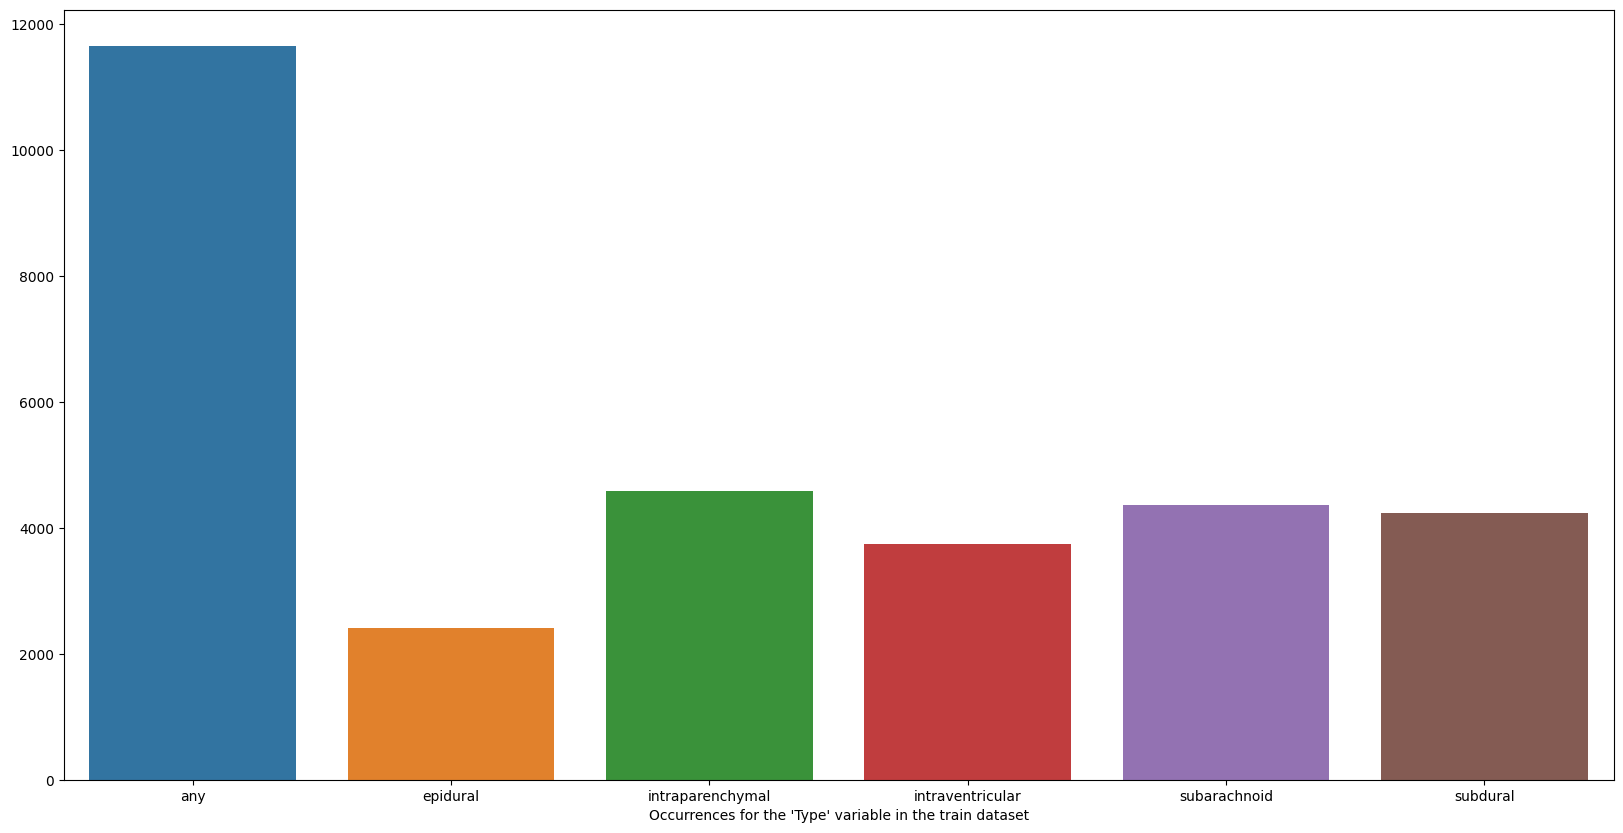

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2.df[hemDatTrain2.df['Label']==1]['Type'], return_counts=True)
print(val, cnt)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

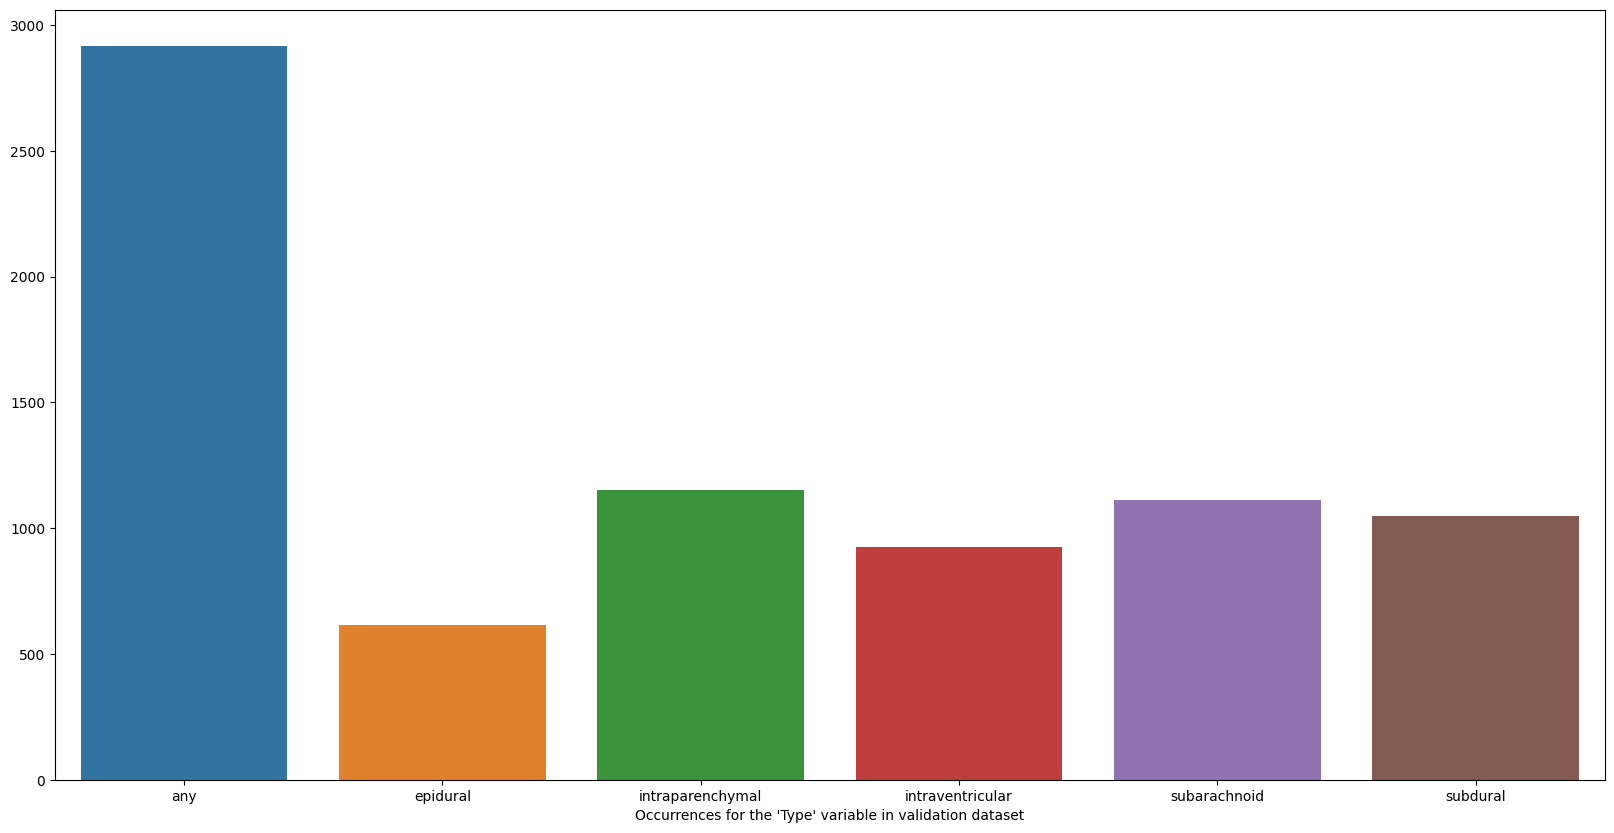

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatVal.df[hemDatVal.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in validation dataset")
sns.barplot(x=val, y=cnt)
plt.show()

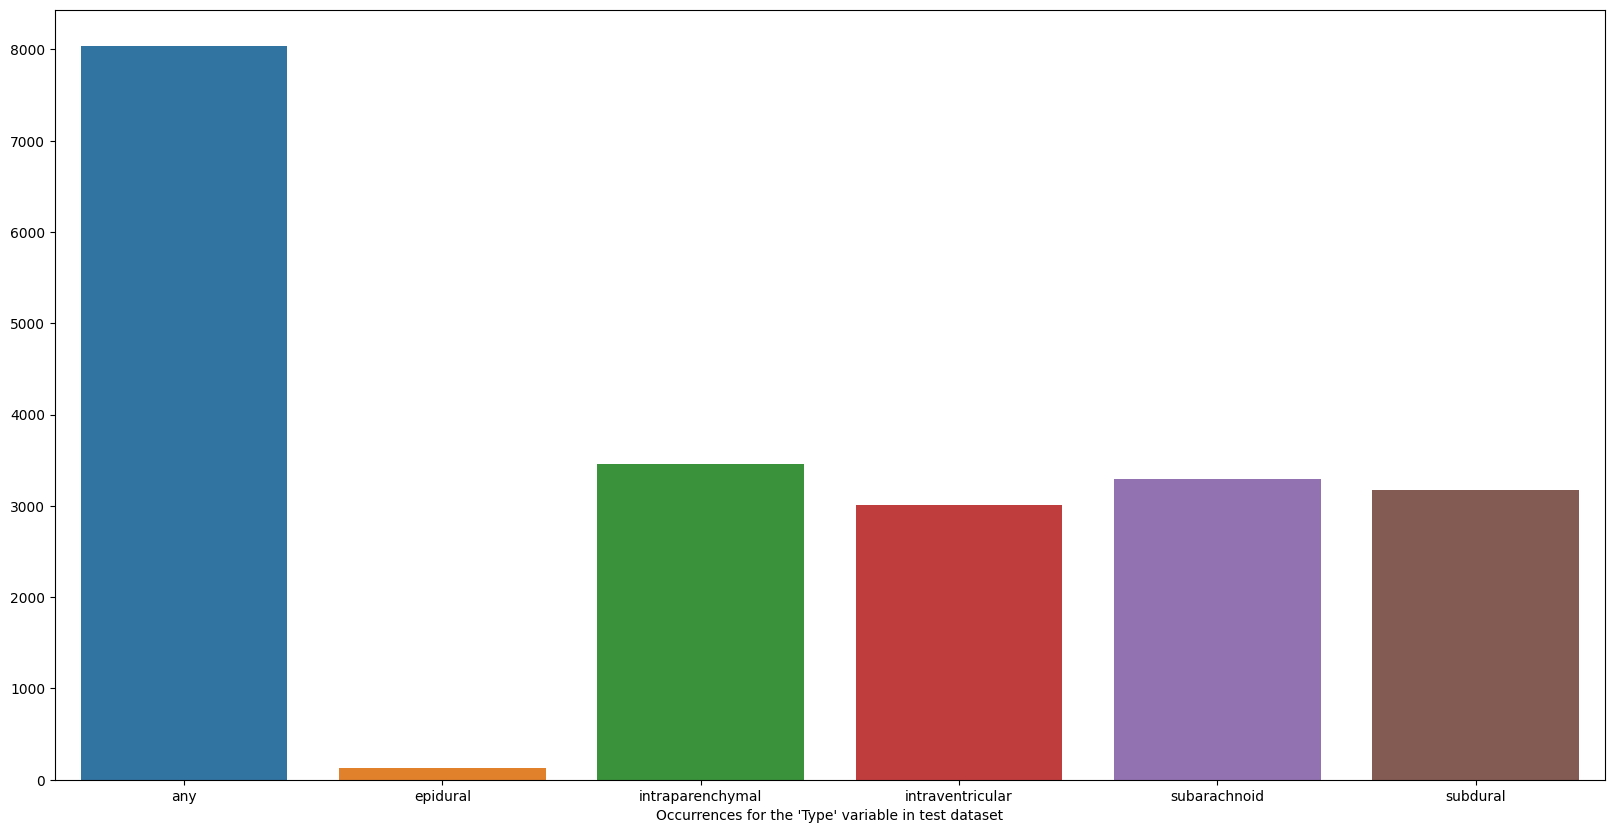

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTest.df[hemDatTest.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in test dataset")
sns.barplot(x=val, y=cnt)
plt.show()

It is obvious that the 'any' variable dominates in the train, validation and test datasets, because it represents whether the other variables are present within an image. In the train and validation dataset, the other variables are not balanced, because the least present variable ('epidural') represents approximately half of the occurrences of the most present variable ('intraparenchymal').

But in the test dataset, 'epidural' is almost non-existant, while have normal proportions.

We could use to handle imbalanced augmentation techniques, SMOTE, oversampling, undersampling or genetic algorithms, which help alleviate this.
We chose to go with the augmentation techniques, which involves

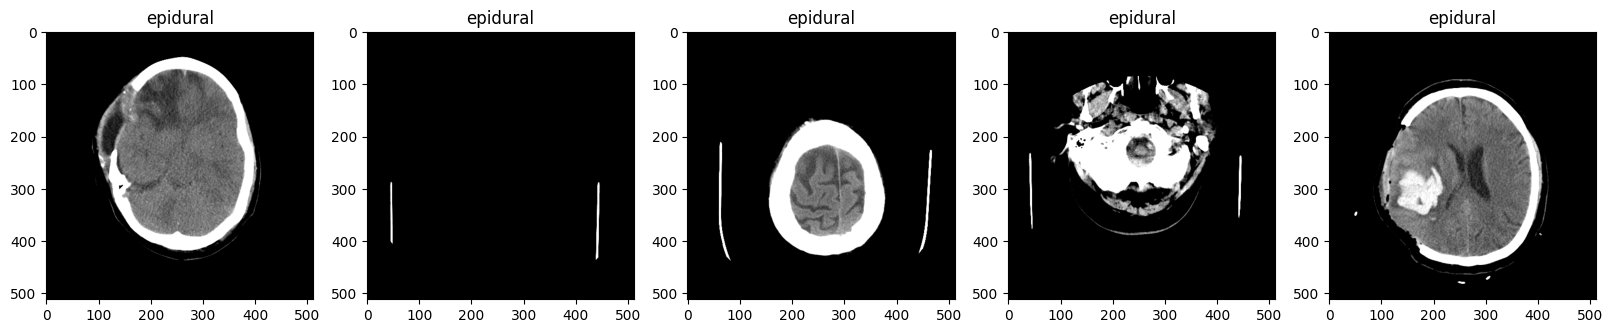

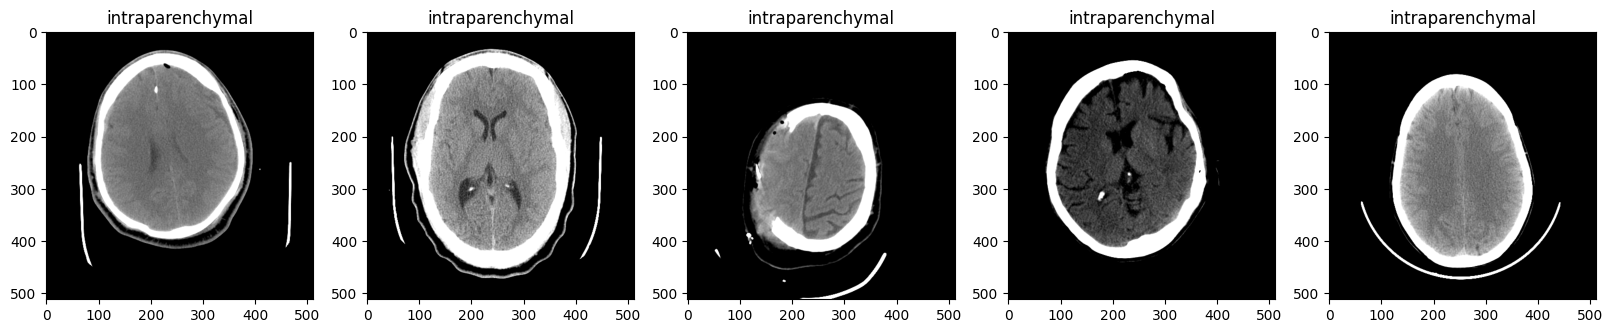

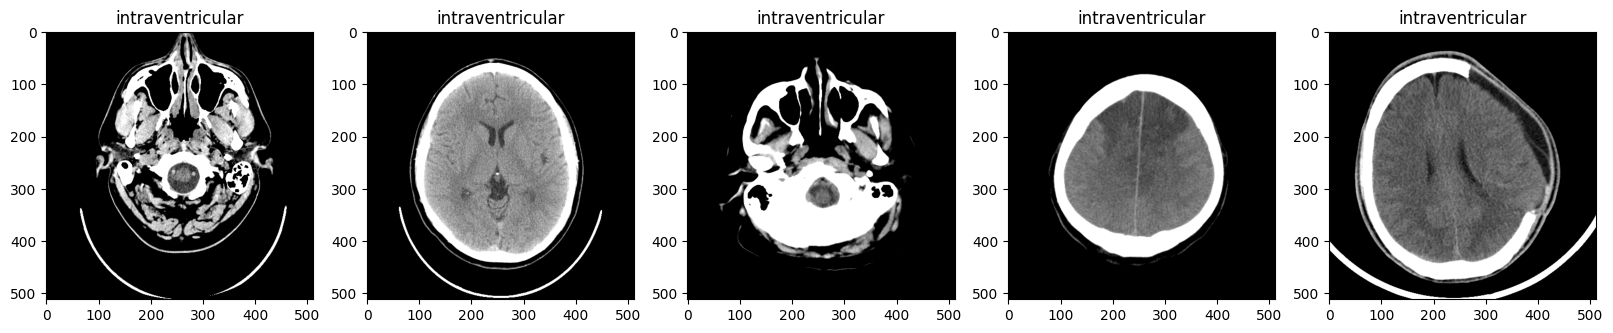

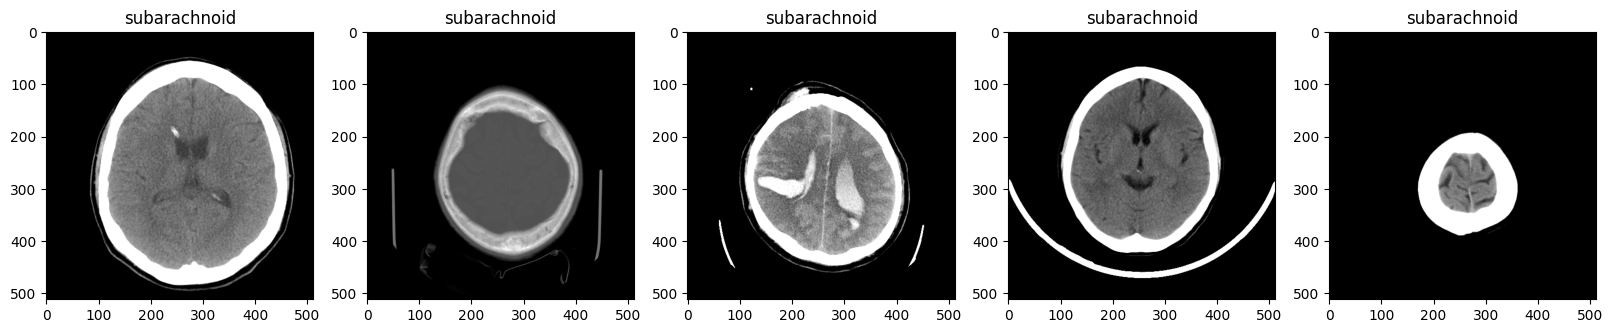

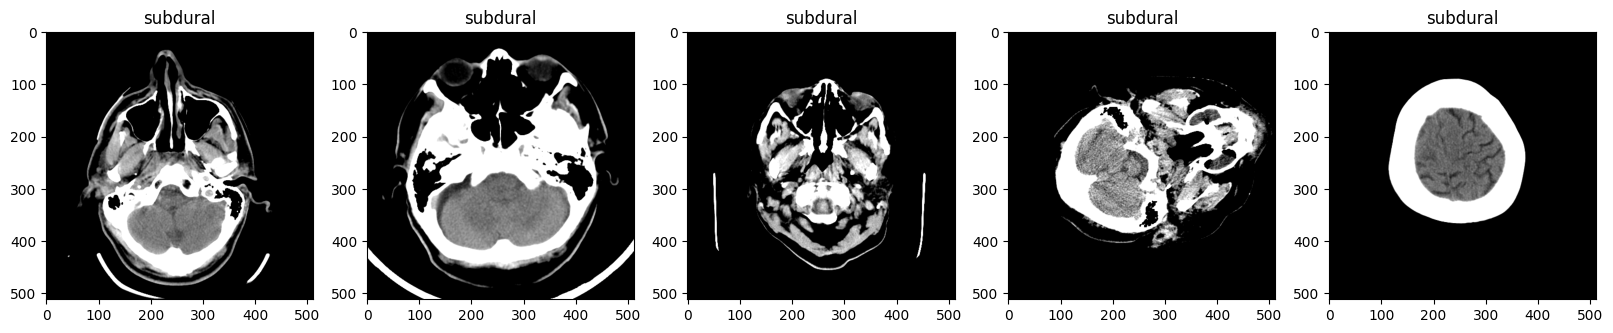

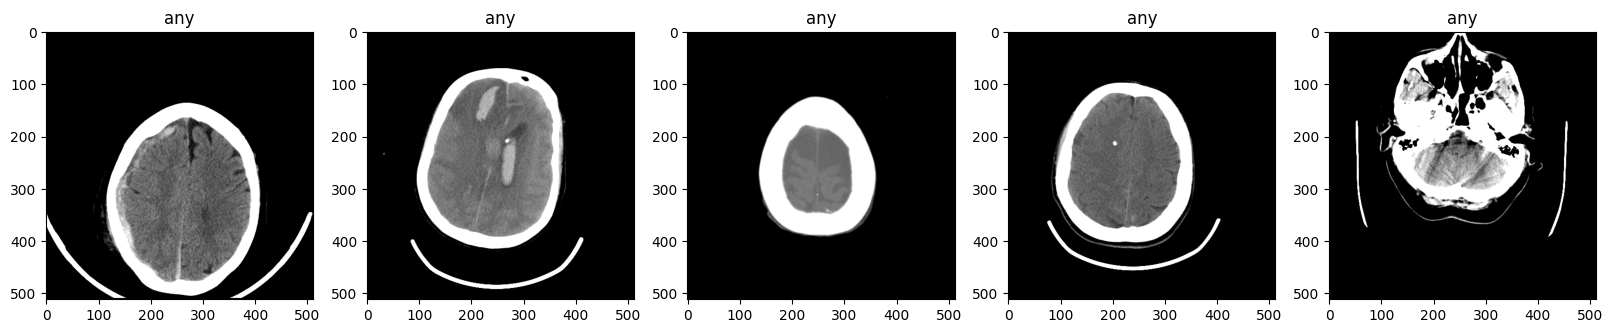

In [14]:
# TODO
import random
num_slices = 10
for cols in hemDatTrain2.df['Type'].unique():
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    current_type_df = hemDatTrain2.df[hemDatTrain2.df['Type']==cols]
    current_type_df = current_type_df[current_type_df['Label']==1]
    elements_r = random.sample(range(len(current_type_df)), 5)
    

    for i,ax in enumerate(axes):
        ax.set_title(cols)
        ax.imshow(PIL.Image.open(hemDatTrain2.file_location[elements_r[i]]), cmap = 'gray')


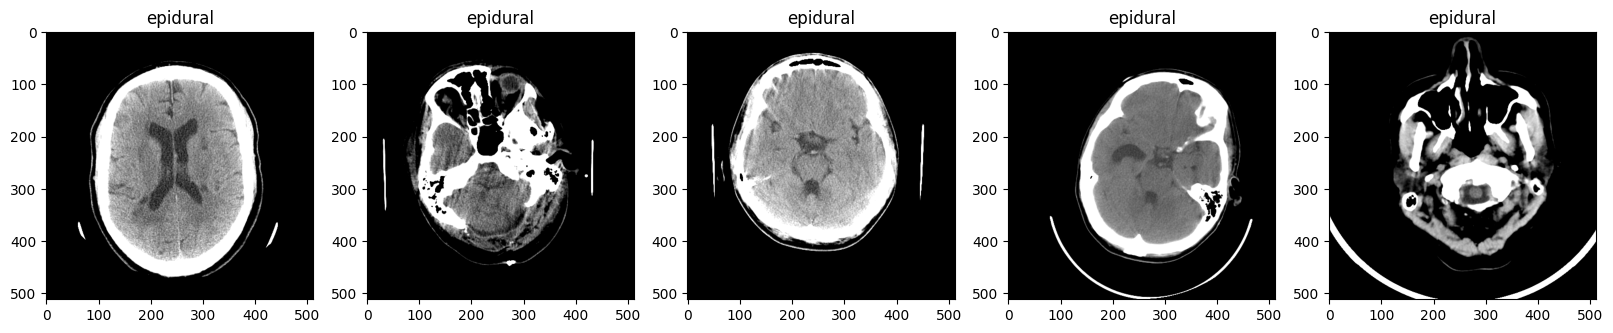

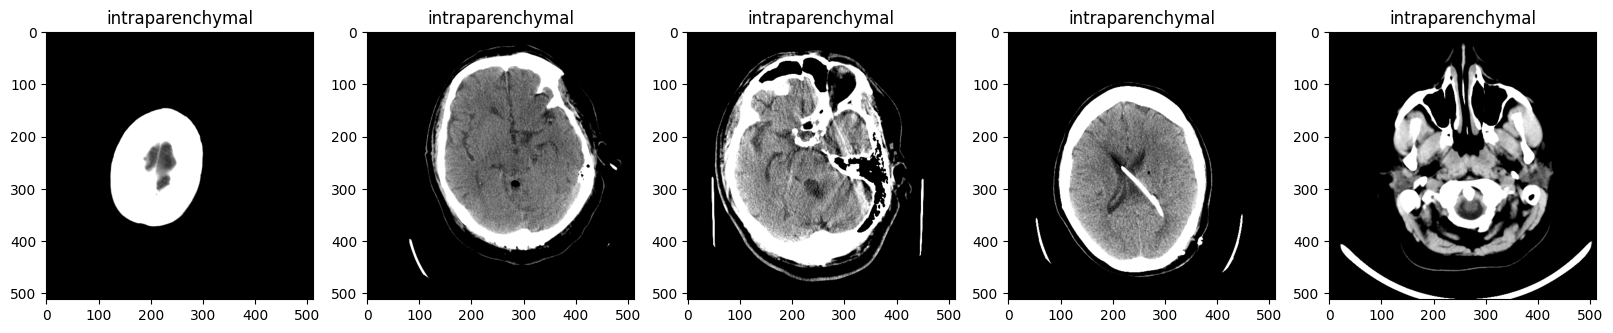

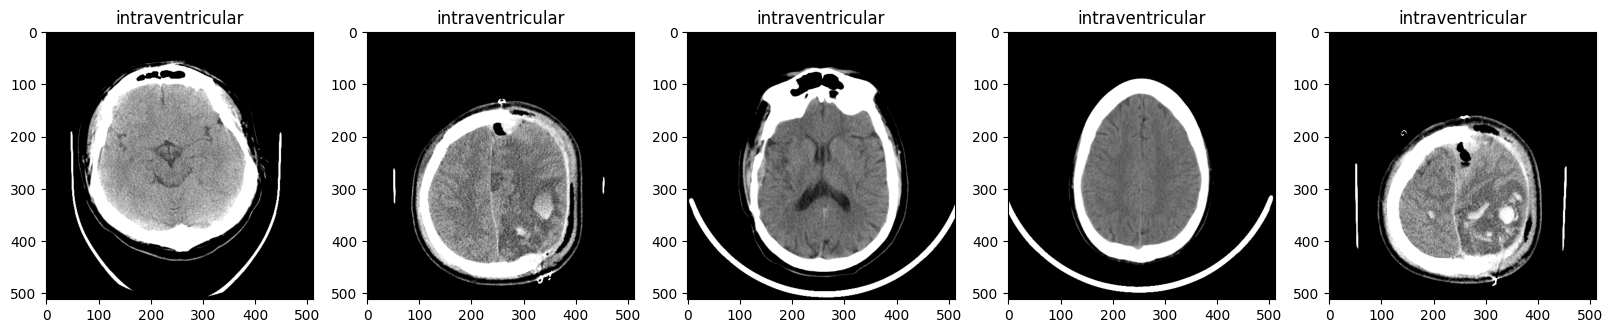

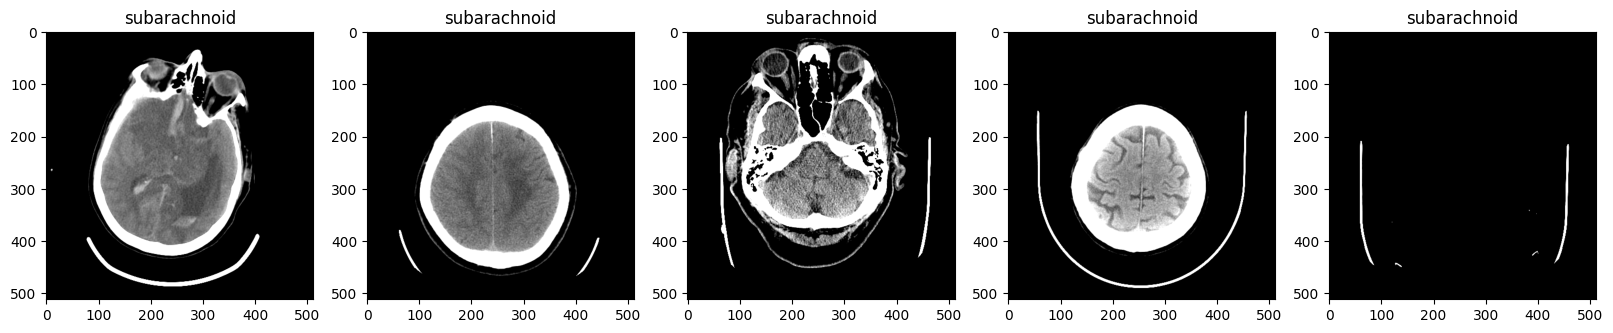

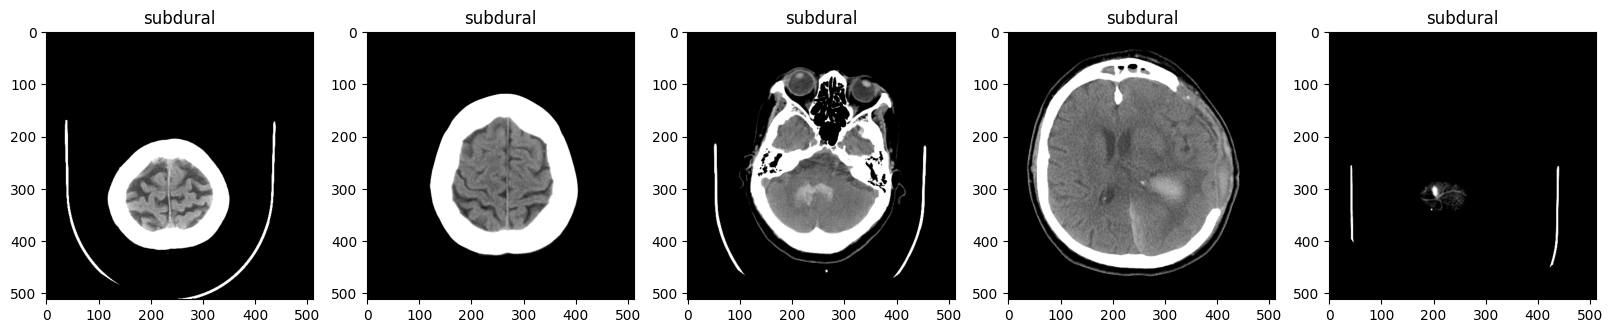

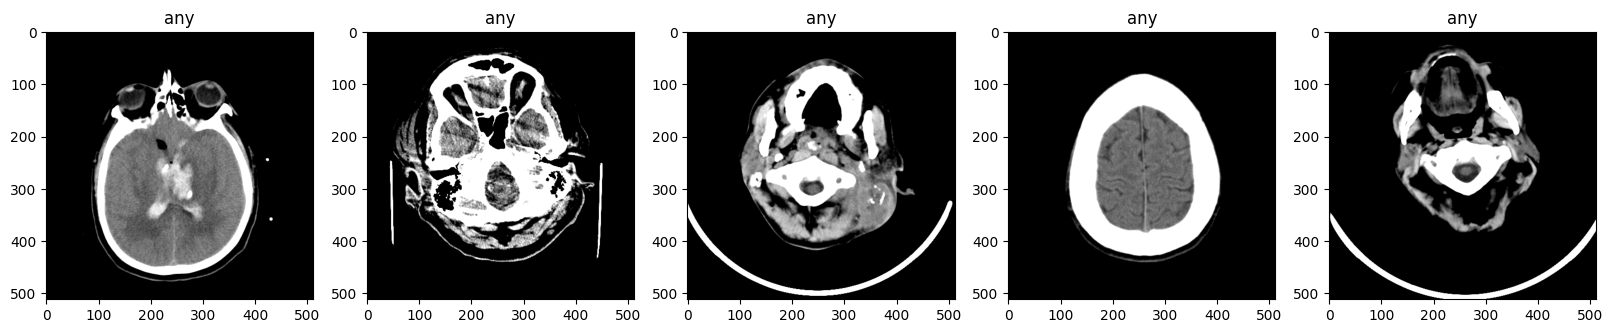

In [15]:
# TODO
import random
num_slices = 10
for cols in hemDatVal.df['Type'].unique():
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    current_type_df = hemDatVal.df[hemDatVal.df['Type']==cols]
    current_type_df = current_type_df[current_type_df['Label']==1]
    elements_r = random.sample(range(len(current_type_df)), 5)
    

    for i,ax in enumerate(axes):
        ax.set_title(cols)
        ax.imshow(PIL.Image.open(hemDatVal.file_location[elements_r[i]]), cmap = 'gray')


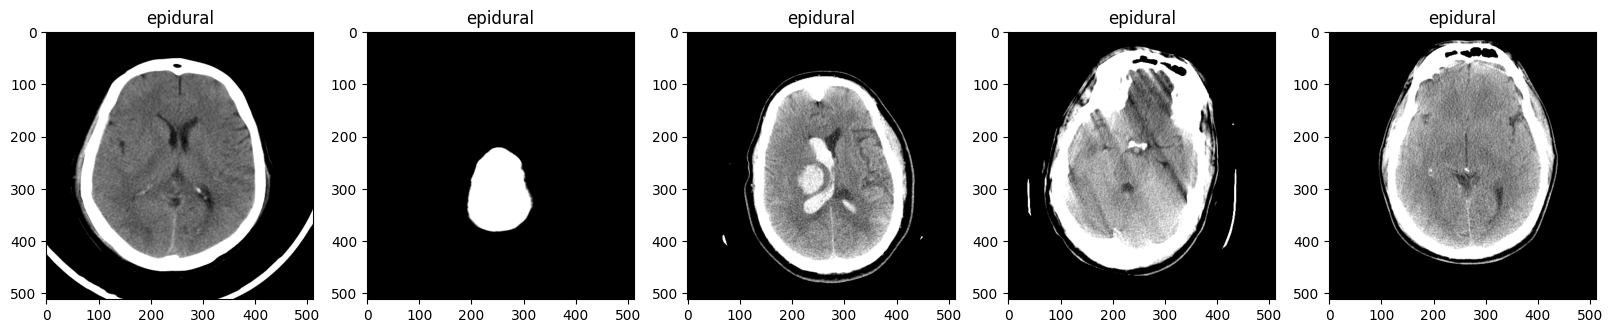

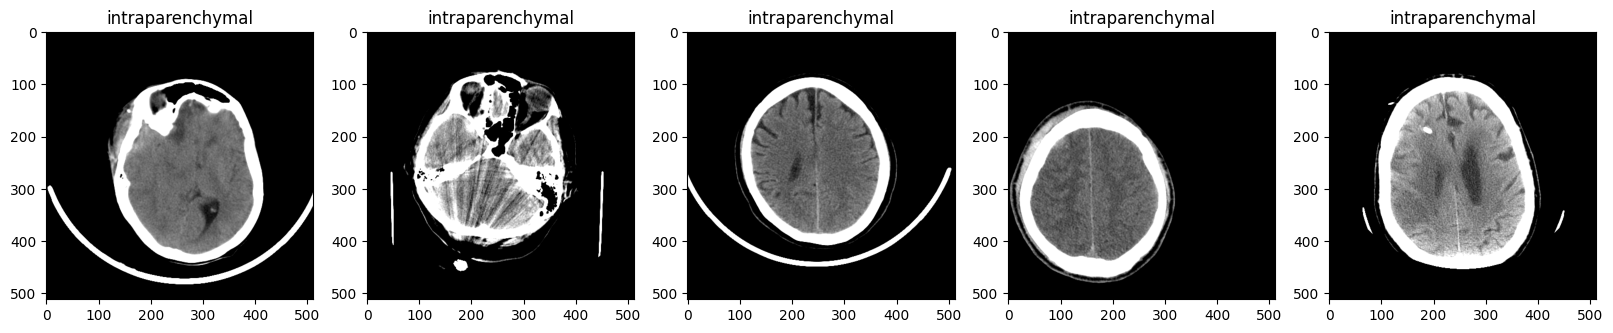

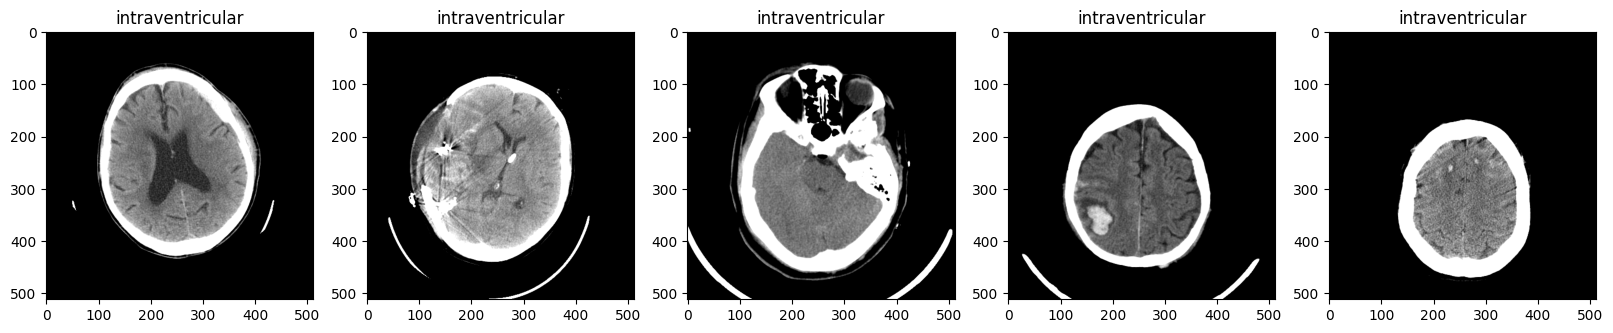

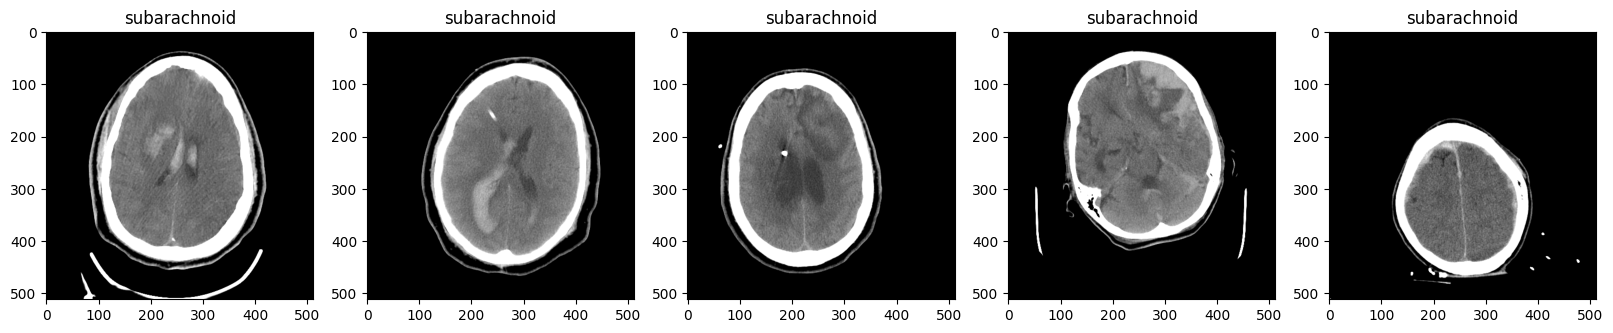

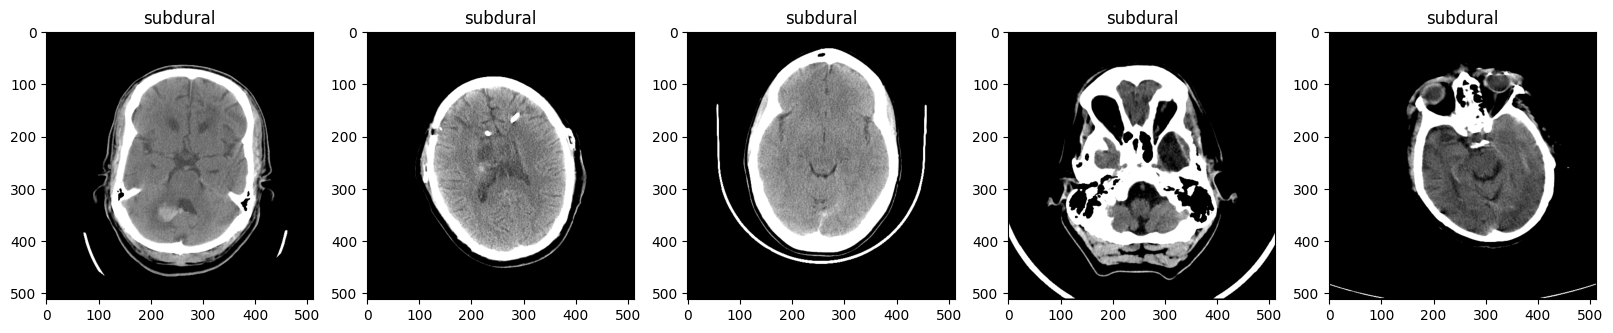

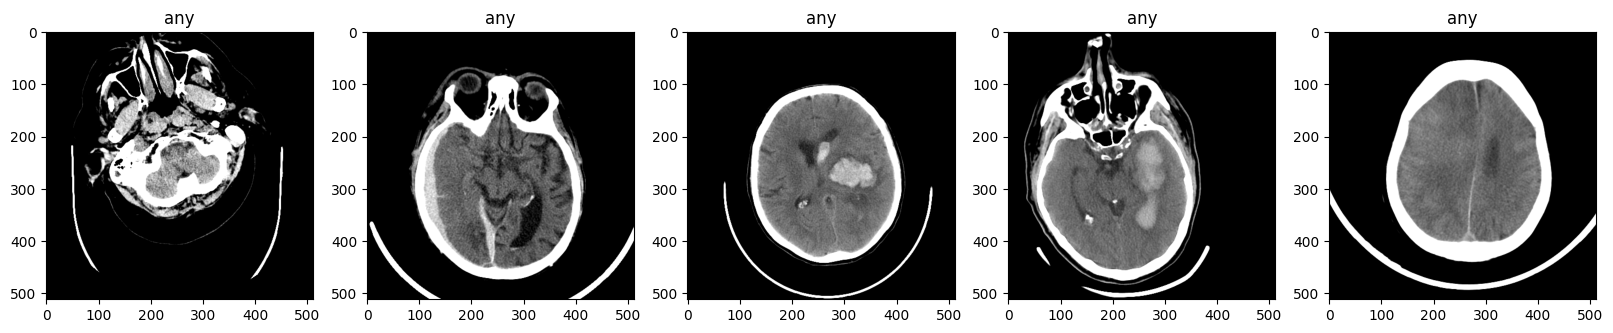

In [16]:
# TODO
import random
num_slices = 10
for cols in hemDatTest.df['Type'].unique():
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    current_type_df = hemDatTest.df[hemDatTest.df['Type']==cols]
    current_type_df = current_type_df[current_type_df['Label']==1]
    elements_r = random.sample(range(len(current_type_df)), 5)
    

    for i,ax in enumerate(axes):
        ax.set_title(cols)
        ax.imshow(PIL.Image.open(hemDatTest.file_location[elements_r[i]]), cmap = 'gray')


To examine more here

In [17]:
from multiprocessing import Pool
with Pool() as p:
    L_test = p.map(PIL.Image.open, hemDatTest.file_location)


In [18]:
test_index = []
_2d_dim_test = []
for i, img in enumerate(L_test):

    element = np.array(img)
    if element.ndim != 2:
        test_index.append(i)
    _2d_dim_test.append(element.shape)
        


In [19]:
from multiprocessing import Pool
with Pool() as p:
    L_train = p.map(PIL.Image.open, hemDatTrain2.file_location)


In [20]:
train_index = []
_2d_dim_train = []
for i, img in enumerate(L_train):
    element = np.array(img)
    if element.ndim != 2:
        train_index.append(i)
    _2d_dim_train.append(element.shape)


In [21]:
from multiprocessing import Pool
with Pool() as p:
    L_val = p.map(PIL.Image.open, hemDatVal.file_location)


In [22]:
train_index = []
_2d_dim_val = []
for i, img in enumerate(L_val):
    element = np.array(img)
    if element.ndim != 2:
        train_index.append(i)
    _2d_dim_val.append(element.shape)


In [23]:
from collections import Counter

_2d_dim_total = _2d_dim_test.copy()
_2d_dim_total.extend(_2d_dim_val)
_2d_dim_total.extend(_2d_dim_train)
most_common_dimension = Counter(_2d_dim_total).most_common()[0][0]


In [24]:
hemDatVal.most_common_size = (128, 128)
hemDatTest.most_common_size = (128, 128)
hemDatTrain2.most_common_size = (128, 128)


We later try to resize the images

In [25]:
id_test = 0
for idx, el in enumerate(L_test):
    
    if np.array(L_test[idx]).shape != most_common_dimension:
        id_test+=1
        
print("Number of bad sizes for test dataset", id_test)

Number of bad sizes for test dataset 5


Try to find the elements with the different sizes from test, train, validation

In [26]:
print(hemDatVal.most_common_size)

(128, 128)


In [27]:
id_train = 0
for idx, el in enumerate(L_train):
    
    if np.array(L_train[idx]).shape != most_common_dimension:
        id_train+=1
print("Number of bad sizes for test dataset", id_train)

Number of bad sizes for test dataset 8


In [28]:
id_val = 0
for idx, el in enumerate(L_val):
    
    if np.array(L_val[idx]).shape != most_common_dimension:
        id_val+=1
print("Number of bad sizes for test dataset", id_val)

Number of bad sizes for test dataset 4


In [29]:
type_float_train = []
type_int_train = []
for idx, el in enumerate(L_train):
    element = np.array(el)
    element_min = element.min()
    element_max = element.max()
    
    if element.dtype=='int':
        type_float_train.append(idx)
    elif element.dtype=='float':
        type_int_train.append(idx)
        
    


In [30]:
type_float_val = []
type_int_val = []
for idx, el in enumerate(L_val):
    element = np.array(el)
    element_min = element.min()
    element_max = element.max()
    
    if element.dtype=='int':
        type_float_train.append(idx)
    elif element.dtype=='float':
        type_int_train.append(idx)
        
    


In [31]:
type_float_test = []
type_int_test = []
for idx, el in enumerate(L_test):
    element = np.array(el)
    element_min = element.min()
    element_max = element.max()
    
    if element.dtype=='int':
        type_float_test.append(idx)
    elif element.dtype=='float':
        type_int_test.append(idx)
        
    


In [32]:
if type_int_test == [] and type_float_test == [] and type_int_train == [] and type_float_train == []:
    print("No Bad scaling")



No Bad scaling


array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

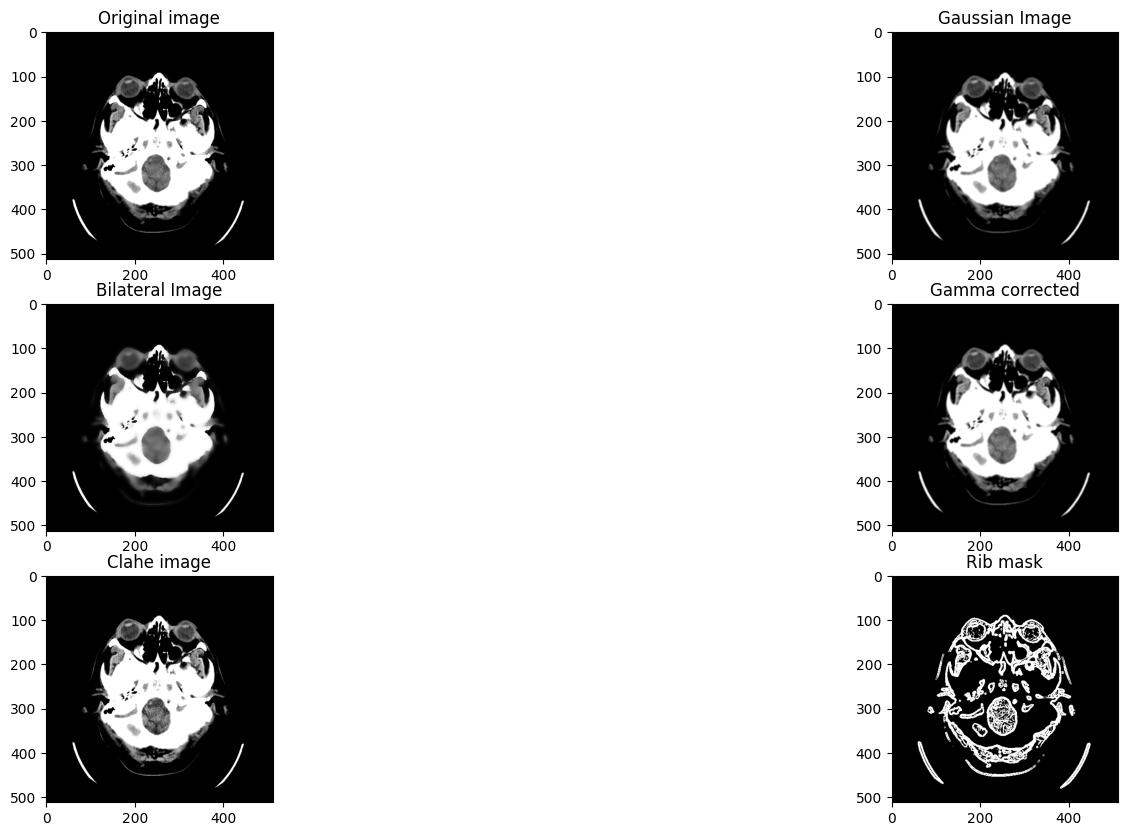

In [33]:
len_elements = hemDatTrain2.df['Type'].nunique()
elements_list = list(set(map(lambda x: x//len_elements, hemDatTrain2.df.index.to_list())))
number = random.choice(elements_list)
hemDatTrain2.__apply_filter__(np.array(PIL.Image.open(hemDatTrain2.file_location[number])), number, False)            

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

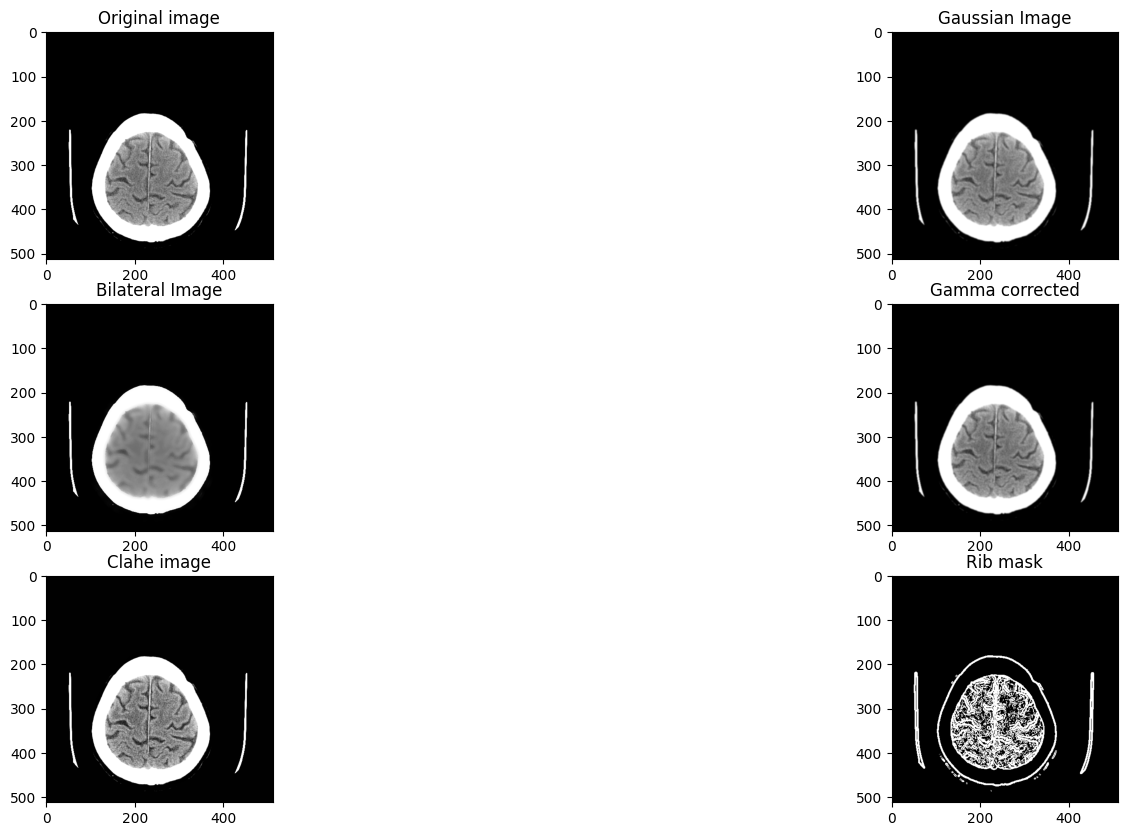

In [34]:
elements_list = list(set(map(lambda x: x//len_elements, hemDatTest.df.index.to_list())))
number = random.choice(elements_list)
hemDatTest.__apply_filter__(np.array(PIL.Image.open(hemDatTest.file_location[number])),number, False)                    

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1.,  1.],
        [ 1.,  1.,  1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1.,  1.],
        [ 1.,  1.,  1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1.,  1.],
        [ 1.,  1.,  1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

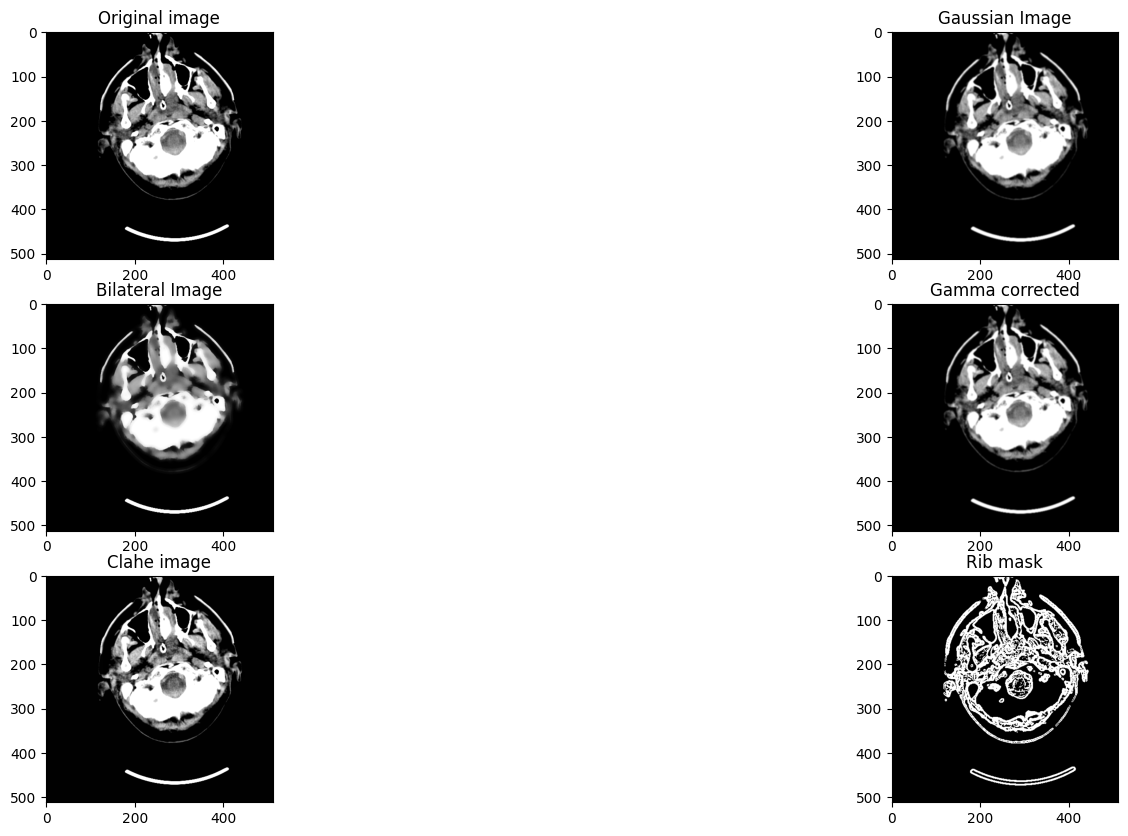

In [35]:
elements_list = list(set(map(lambda x: x//len_elements, hemDatVal.df.index.to_list())))
number = random.choice(elements_list)
hemDatVal.__apply_filter__(np.array(PIL.Image.open(hemDatVal.file_location[number])),number, False)                    

We show the transformation for a random image from the train, test, val

In [36]:
val, cnt = np.unique(hemDatTrain2.df[hemDatTrain2.df['Label']==1]['Type'], return_counts=True)


In [37]:
from torch.utils.data import Subset
import operator
import torch

hemDatTrain2_c =  Subset(hemDatTrain2, list(range(len(hemDatTrain2))))

hemDatTrain2_c.file_location = hemDatTrain2.file_location
hemDatTrain2_c.df = hemDatTrain2.df
hemDatTrain2_c.transform = hemDatTrain2.transform
hemDatTrain2_c.is_train = hemDatTrain2.is_train

val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
exclude_any_best_value = max(cnt[1:])
exclude_any_best_value_index = np.argmax(cnt[1:])+1
threshold = max(cnt) - min(cnt)

while threshold > 200:
    for index_col in range(len(val)):
        if index_col == 0 or index_col == exclude_any_best_value_index:
                continue
        different_elements = hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]
        different_elements= different_elements[different_elements['Type'] == val[index_col]]
        if exclude_any_best_value-cnt[index_col] == 0:
            continue
        elements_to_choose = random.sample(different_elements.index.to_list(), exclude_any_best_value-cnt[index_col])
        index_dif_el = list(map(lambda x: x//6, elements_to_choose))
        remaining_indices = list(set(different_elements.index.to_list()) - set(index_dif_el))
        f_l = operator.itemgetter(*index_dif_el)(hemDatTrain2_c.file_location.copy())
        list_elements = []
        
        for idx in index_dif_el:
            list_elements.extend(list(range(6*idx, 6*(idx+1))))
        our_df = pd.concat([hemDatTrain2_c.df.loc[list_elements, :]], ignore_index=True)
        our_transformed = operator.itemgetter(*index_dif_el)(hemDatTrain2_c.transform.copy())
        
        subset_dataset = Subset(hemDatTrain2_c, index_dif_el)
        my_final_list = hemDatTrain2_c.file_location.copy()
        Transforms = hemDatTrain2_c.transform.copy()
        df_og = hemDatTrain2_c.df
        
        hemDatTrain2_c = torch.utils.data.ConcatDataset([hemDatTrain2_c, subset_dataset])
        my_final_list.extend(f_l)
        
        hemDatTrain2_c.file_location = my_final_list
        
        our_df = pd.concat([df_og, our_df], ignore_index=True)
        hemDatTrain2_c.df = our_df
        
        
        Transforms.extend(our_transformed)
        
        hemDatTrain2_c.transform = Transforms
        hemDatTrain2_c.is_train = hemDatTrain2.is_train
    val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
    threshold = max(cnt[1:]) - min(cnt[1:])
    exclude_any_best_value = max(cnt[1:])
    exclude_any_best_value_index = np.argmax(cnt[1:])+1



We try to balance the type, by inserting image augmentations, and we stop until the difference between the maximum and minimum is less than 200.

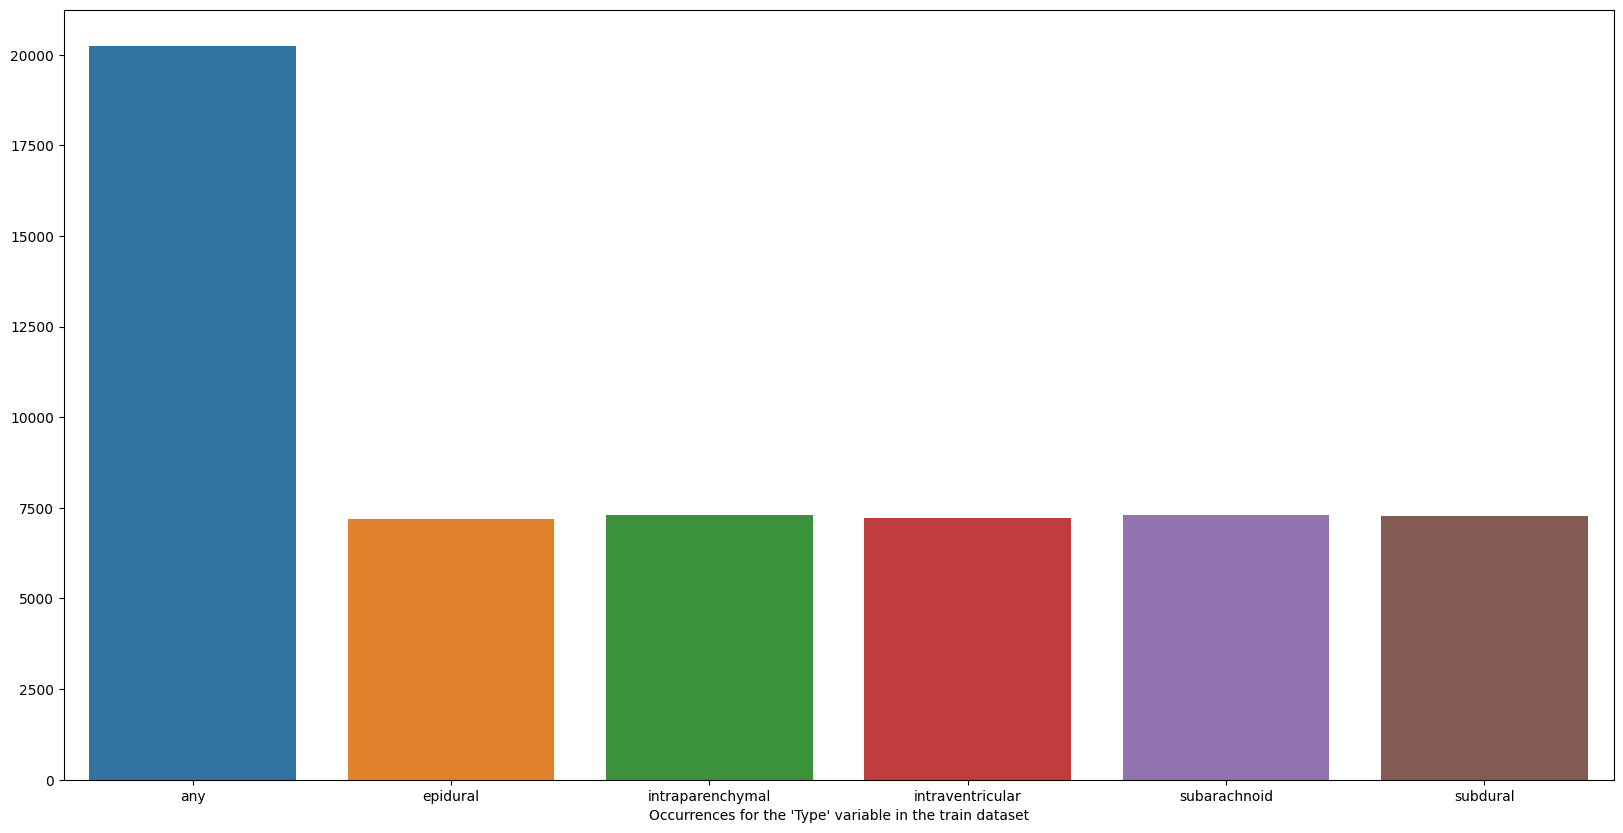

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(hemDatTrain2_c.df[hemDatTrain2_c.df['Label']==1]['Type'], return_counts=True)
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in the train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

In [39]:
batch_size = 64
import torch
train_loader = torch.utils.data.DataLoader(hemDatTrain2_c, batch_size = batch_size, shuffle = True, num_workers=4)
val_loader = torch.utils.data.DataLoader(hemDatVal, batch_size = batch_size, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(hemDatTest, batch_size = batch_size, shuffle = True, num_workers=4)

In [40]:
val_shape = ()
out_shape = ()
for key, value in {'Training data': train_loader, "Validation data": val_loader, "Test data": test_loader}.items():
    for X, y in value:
        val_shape = X.shape
        out_shape = y.shape
        
        print(f"Shape of X : {X.shape}")    
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Shape of X : torch.Size([64, 3, 128, 128])
Training data:
Shape of X : torch.Size([64, 3, 128, 128])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 128, 128])
Validation data:
Shape of X : torch.Size([64, 3, 128, 128])
Shape of y: torch.Size([64, 6]) torch.float32

Shape of X : torch.Size([64, 3, 128, 128])
Test data:
Shape of X : torch.Size([64, 3, 128, 128])
Shape of y: torch.Size([64, 6]) torch.float32



In [41]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)
    pred = (nn.Sigmoid()(output)>0.5).float()  # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() 

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [42]:
from tqdm.notebook import trange, tqdm
def Train_Val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')


    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*(val_metric/6):.2f}")
        print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history, best_model_wts

In [43]:
import copy
import torchvision
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
from torchvision.models import resnet18, ResNet18_Weights,efficientnet_b4
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model = resnet18(num_classes=6)
if torch.cuda.is_available():
    cnn_model.cuda()
cnn_model.to(device)

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4, weight_decay=1e-4),
 "lr_change": ReduceLROnPlateau(optim.Adam(cnn_model.parameters(),lr=3e-4, weight_decay=1e-4),
                                mode='min',
                                factor=0.5,
                                patience=20),
 "f_loss": torch.nn.BCEWithLogitsLoss(),
 "weight_path": "weights.pt",
}

# train and validate the model
resnet_model,loss_hist,metric_hist,best_model_wts = Train_Val(cnn_model,params_train, verbose=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 0/59, current lr=0.0003
Copied best model weights!
train loss: 0.004905, dev loss: 0.005080, accuracy: 87.25
----------
Epoch 1/59, current lr=0.0003
Copied best model weights!
train loss: 0.004163, dev loss: 0.004163, accuracy: 89.14
----------
Epoch 2/59, current lr=0.0003
train loss: 0.003740, dev loss: 0.004181, accuracy: 88.82
----------
Epoch 3/59, current lr=0.0003
train loss: 0.003364, dev loss: 0.005557, accuracy: 84.22
----------
Epoch 4/59, current lr=0.0003
Copied best model weights!
train loss: 0.002949, dev loss: 0.003941, accuracy: 89.97
----------
Epoch 5/59, current lr=0.0003
train loss: 0.002553, dev loss: 0.004392, accuracy: 88.47
----------
Epoch 6/59, current lr=0.0003
train loss: 0.002140, dev loss: 0.004268, accuracy: 90.28
----------
Epoch 7/59, current lr=0.0003
train loss: 0.001783, dev loss: 0.004012, accuracy: 90.29
----------
Epoch 8/59, current lr=0.0003
train loss: 0.001405, dev loss: 0.005623, accuracy: 89.62
----------
Epoch 9/59, current lr=0.000

In [44]:
for idx, (train, val) in enumerate(zip(metric_hist['train'], metric_hist['val'])):
    print(f"Iteration {idx}. Accurracy for train :{train/6*100}. Accurracy for val :{val/6*100}")


Iteration 0. Accurracy for train :86.89235261492284. Accurracy for val :87.25065047701648
Iteration 1. Accurracy for train :88.7201885745979. Accurracy for val :89.13806632800562
Iteration 2. Accurracy for train :89.89918762846236. Accurracy for val :88.82418535497459
Iteration 3. Accurracy for train :90.9521712179048. Accurracy for val :84.22335109238838
Iteration 4. Accurracy for train :92.15237675769143. Accurracy for val :89.97232891421963
Iteration 5. Accurracy for train :93.31710221526214. Accurracy for val :88.4710692603147
Iteration 6. Accurracy for train :94.51853120615966. Accurracy for val :90.2820798744476
Iteration 7. Accurracy for train :95.4817950474699. Accurracy for val :90.2924049064552
Iteration 8. Accurracy for train :96.4972594695116. Accurracy for val :89.61921281955973
Iteration 9. Accurracy for train :97.13386186421324. Accurracy for val :88.68376491967126
Iteration 10. Accurracy for train :97.65545985449087. Accurracy for val :90.31924998967497
Iteration 11. Ac

In [ ]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)
    pred = (nn.Sigmoid()(output)>0.5).float()  # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() 

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [45]:
loss_func = torch.nn.BCEWithLogitsLoss()
test_loss, test_metric = loss_epoch(resnet_model,loss_func,test_loader)

print(f"Test loss :{test_loss}. Accurracy for test :{test_metric/6*100}")


Test loss :0.00763993887355293. Accurracy for test :78.79349739671123


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: >

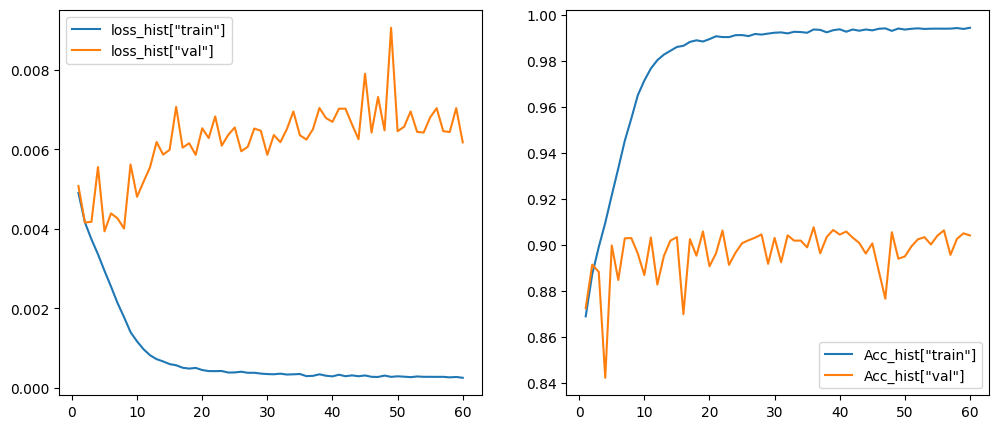

In [48]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))
list_metric_train = list(map(lambda x: x/6, metric_hist["train"]))
list_metric_val = list(map(lambda x: x/6, metric_hist["val"]))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_train,ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=list_metric_val,ax=ax[1],label='Acc_hist["val"]')

In [184]:
# define function For Classification Report
import torch
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        pred = (nn.Sigmoid()(outputs)>0.5).float()
        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())

    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, resnet_model)



In [185]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val = (hemDatVal.df['Type'][0:6])


In [186]:
import numpy as np
import torch
from sklearn.metrics import multilabel_confusion_matrix

labels = list(val)
mcm = multilabel_confusion_matrix(y_true, y_pred)
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

for i, matrix in enumerate(mcm):
    print(f"{labels[i]}")
    print(matrix)
    tn, fp, fn, tp = matrix.ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n")
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)


epidural
[[7396   60]
 [ 416  199]]
TN: 7396, FP: 60, FN: 416, TP: 199

intraparenchymal
[[6782  136]
 [ 618  535]]
TN: 6782, FP: 136, FN: 618, TP: 535

intraventricular
[[6752  394]
 [ 193  732]]
TN: 6752, FP: 394, FN: 193, TP: 732

subarachnoid
[[6668  290]
 [ 699  414]]
TN: 6668, FP: 290, FN: 699, TP: 414

subdural
[[6793  231]
 [ 726  321]]
TN: 6793, FP: 231, FN: 726, TP: 321

any
[[4640  516]
 [ 577 2338]]
TN: 4640, FP: 516, FN: 577, TP: 2338



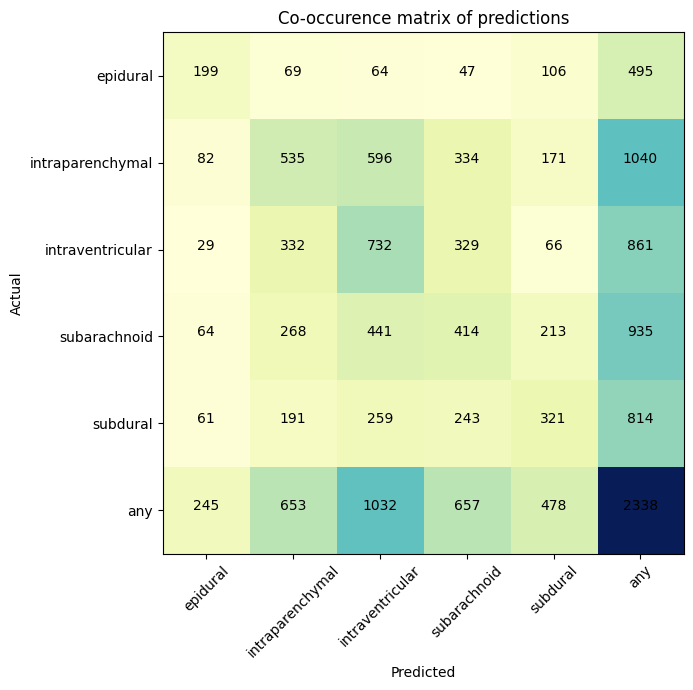

<Figure size 640x480 with 0 Axes>

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_occurance_matrix(mcm, labels, y_true, y_pred, title='Co-occurence matrix of predictions', cmap=plt.cm.YlGnBu):
    matrix = y_true.T @ y_pred
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(labels))

    plt.xticks(tick_marks, [f"{value}" for key , value in enumerate(labels)], rotation=45)
    plt.yticks(tick_marks, [f"{value}" for key , value in enumerate(labels)])

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, f"{matrix[i,j]}", horizontalalignment="center", color="black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()    
    plt.tight_layout()
    plt.show()

plot_occurance_matrix(mcm, labels, np.array(y_true).astype(int), np.array(y_pred).astype(int))

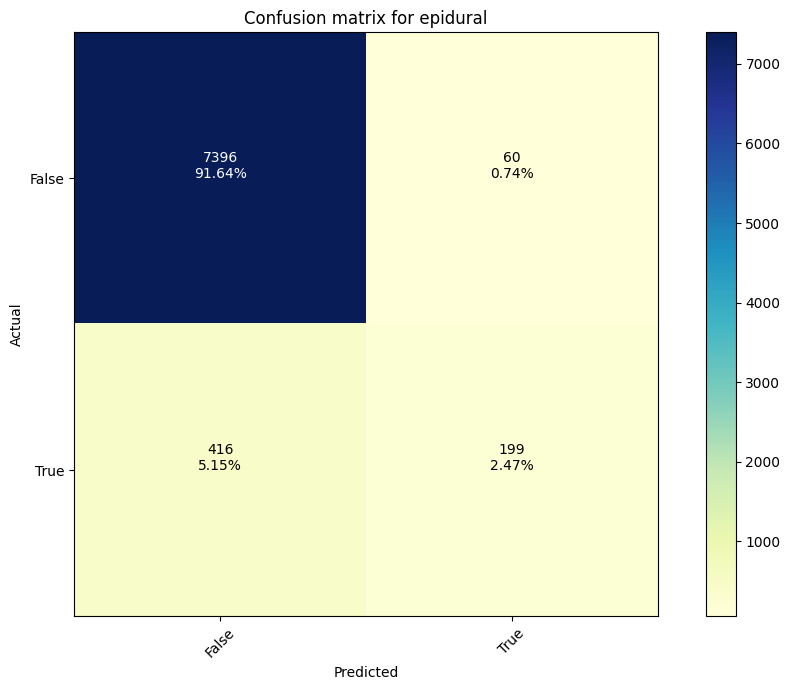

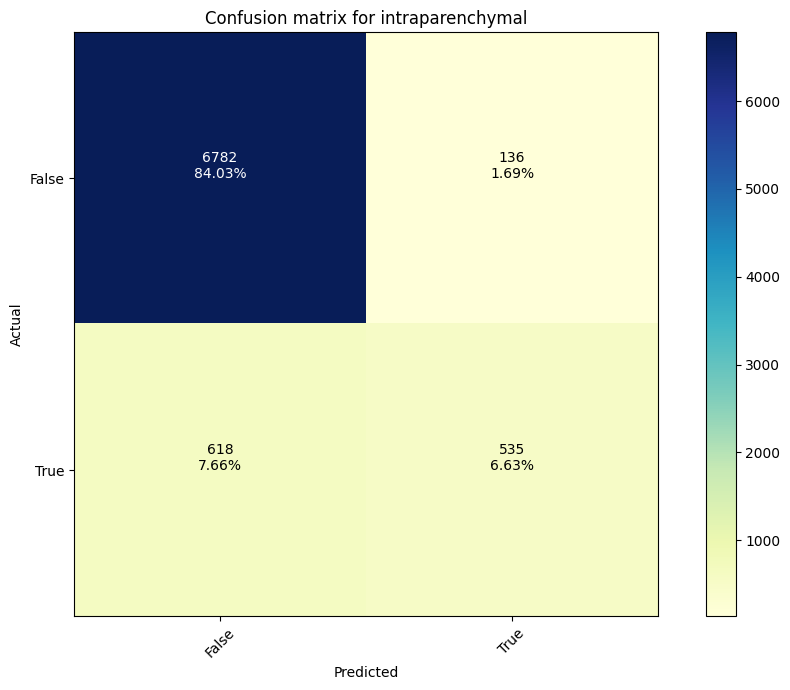

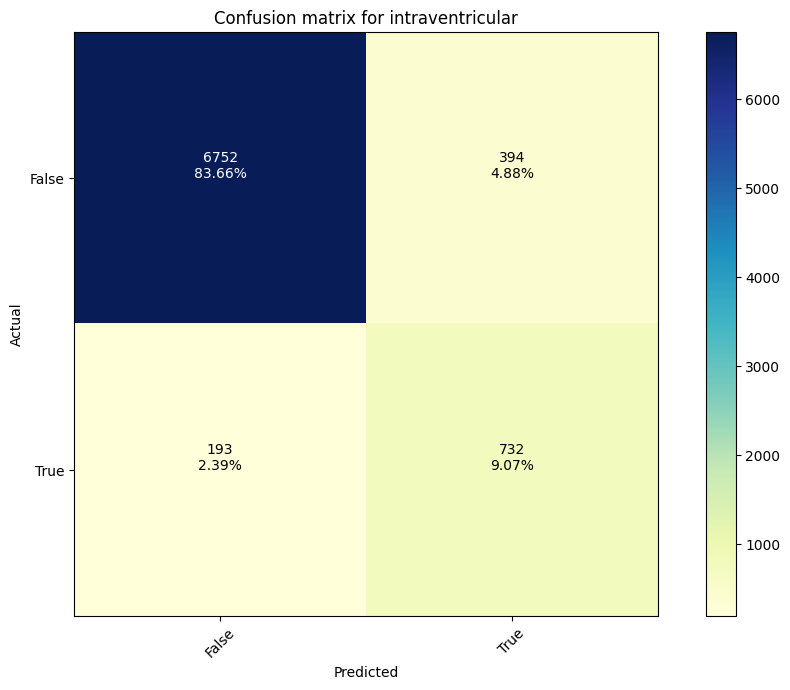

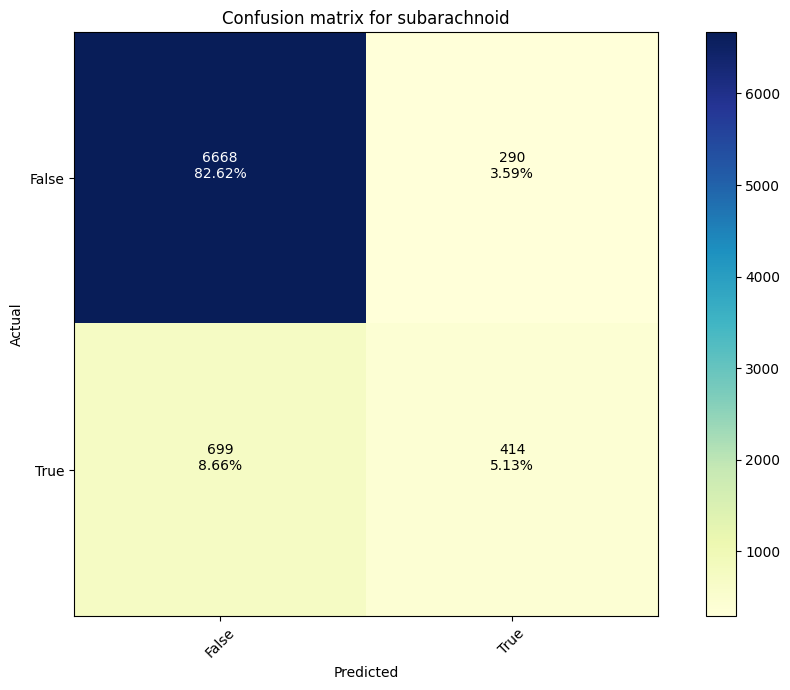

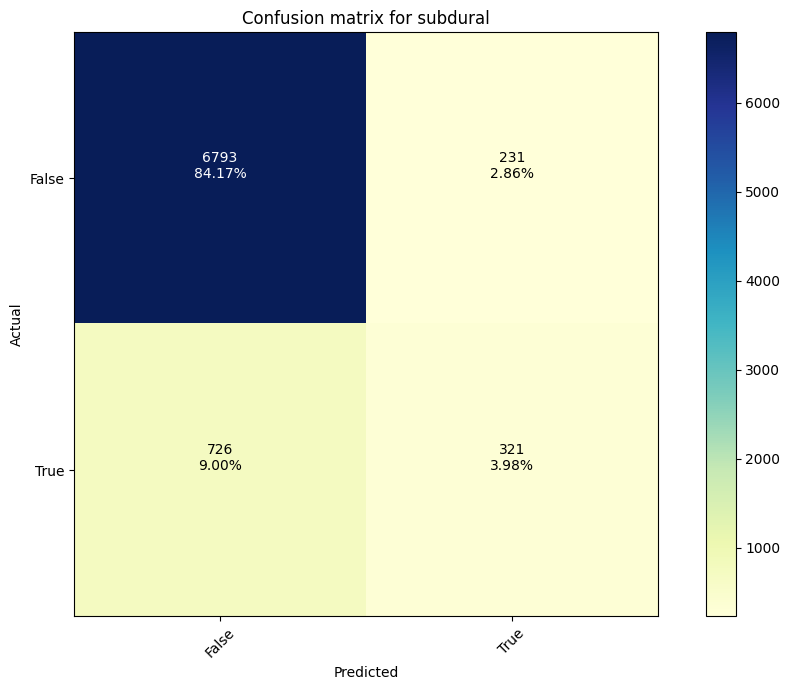

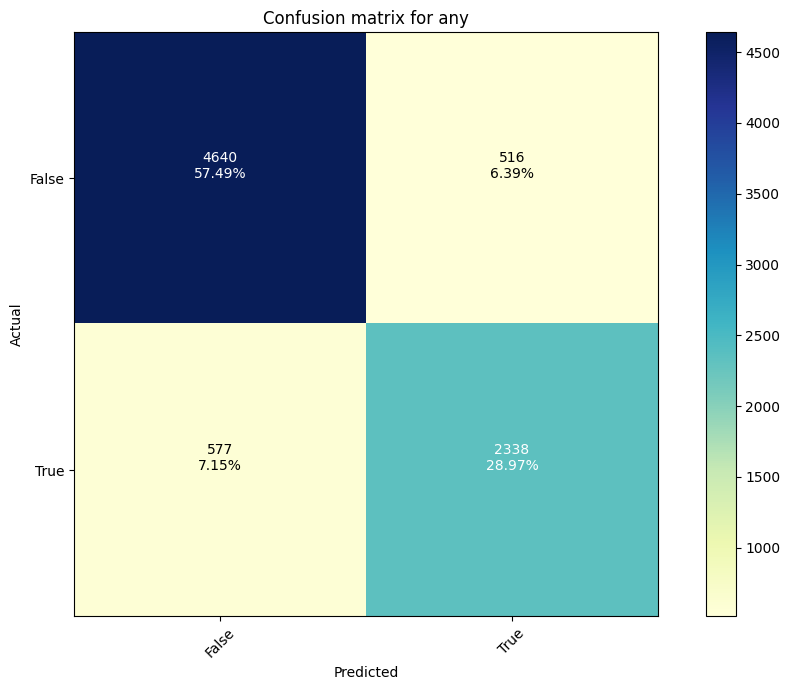

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{title} for {label}")
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}" for value in CLA_label], rotation=45)
    plt.yticks(tick_marks, [f"{value}" for value in CLA_label])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

for idx, cm in enumerate(mcm):
    show_confusion_matrix(mcm[idx], [False, True], labels[idx])



In [191]:

from sklearn.metrics import f1_score, recall_score, precision_score

list_elements = ["accuracy", "precision", "recall", "f1-score"]
for i in range(len(labels)):
    print(f" {labels[i]} \n accuracy:{accuracy_list[i]}\n precision:{precision_list[i]}\n recall:{recall_list[i]}\n f1_score:{f1_score_list[i]}\n")


for elements in ["micro", "macro", "weighted"]:
    f1 = f1_score(y_true, y_pred, average=elements)
    recall = recall_score(y_true, y_pred, average=elements)
    precision = precision_score(y_true, y_pred, average=elements)
    print(f" {elements}\n precision:{precision}\n recall:{recall}\n f1-score:{f1}\n")


 epidural 
 accuracy:0.9410234171725932
 precision:0.7683397683397684
 recall:0.3235772357723577
 f1_score:0.45537757437070936

 intraparenchymal 
 accuracy:0.9065791103952422
 precision:0.797317436661699
 recall:0.4640069384215091
 f1_score:0.5866228070175438

 intraventricular 
 accuracy:0.9272704745384711
 precision:0.650088809946714
 recall:0.7913513513513514
 f1_score:0.7137981472452463

 subarachnoid 
 accuracy:0.8774625201338124
 precision:0.5880681818181818
 recall:0.3719676549865229
 f1_score:0.45569620253164556

 subdural 
 accuracy:0.8814273324247305
 precision:0.5815217391304348
 recall:0.30659025787965616
 f1_score:0.40150093808630394

 any 
 accuracy:0.8645768801883286
 precision:0.8192011212333566
 recall:0.8020583190394511
 f1_score:0.8105390882301958

 micro
 precision:0.7361336360687641
 recall:0.5843202883625128
 f1-score:0.6514999282330989

 macro
 precision:0.7007561761883591
 recall:0.5099252929084747
 f1-score:0.5705891262469409

 weighted
 precision:0.7266365250

In [192]:
y_true, y_pred = Ture_and_Pred(test_loader, resnet_model)


labels = list(val)
mcm = multilabel_confusion_matrix(y_true, y_pred)
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

for i, matrix in enumerate(mcm):
    print(f"{labels[i]}")
    print(matrix)
    tn, fp, fn, tp = matrix.ravel()
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n")
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)

epidural
[[8633  143]
 [  80   43]]
TN: 8633, FP: 143, FN: 80, TP: 43

intraparenchymal
[[5013  423]
 [1788 1675]]
TN: 5013, FP: 423, FN: 1788, TP: 1675

intraventricular
[[4878 1010]
 [ 619 2392]]
TN: 4878, FP: 1010, FN: 619, TP: 2392

subarachnoid
[[4849  758]
 [2071 1221]]
TN: 4849, FP: 758, FN: 2071, TP: 1221

subdural
[[5344  385]
 [2275  895]]
TN: 5344, FP: 385, FN: 2275, TP: 895

any
[[ 778   87]
 [1684 6350]]
TN: 778, FP: 87, FN: 1684, TP: 6350



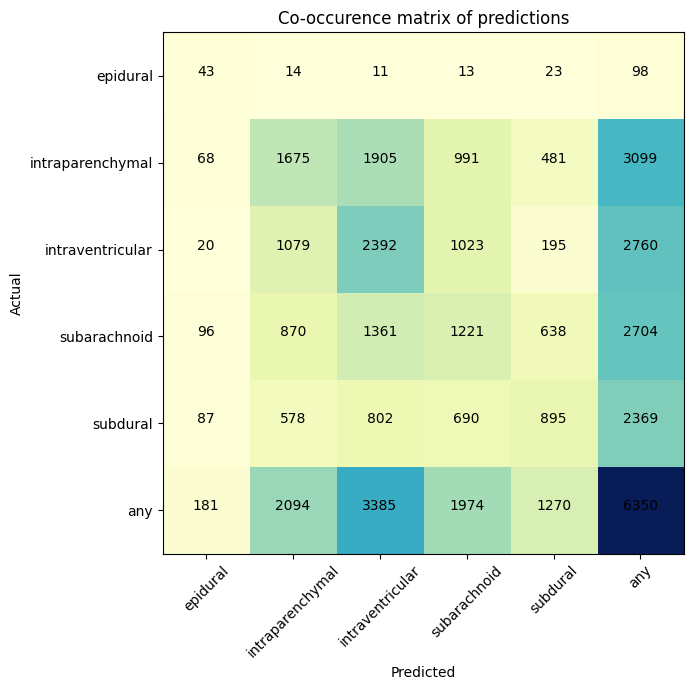

<Figure size 640x480 with 0 Axes>

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_occurance_matrix(mcm, labels, np.array(y_true).astype(int), np.array(y_pred).astype(int))

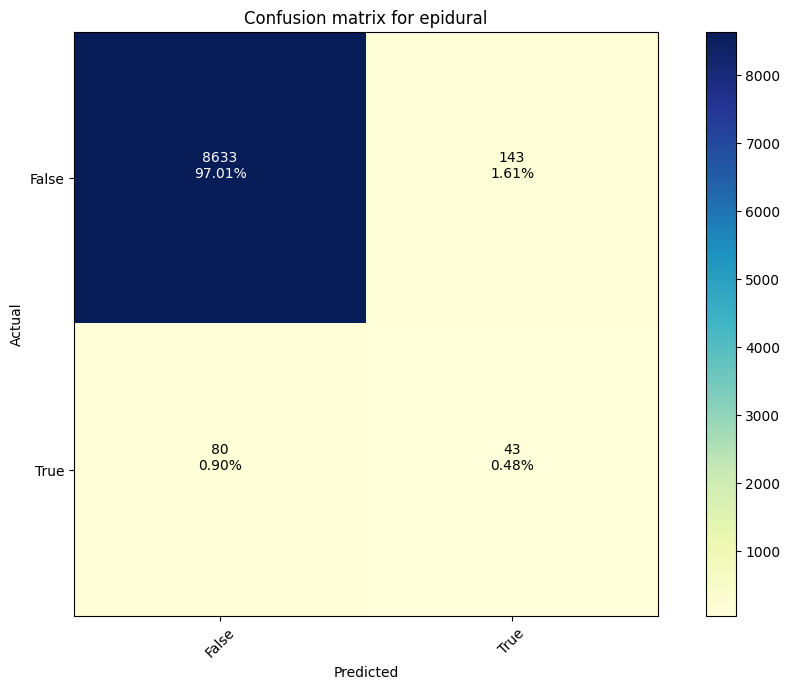

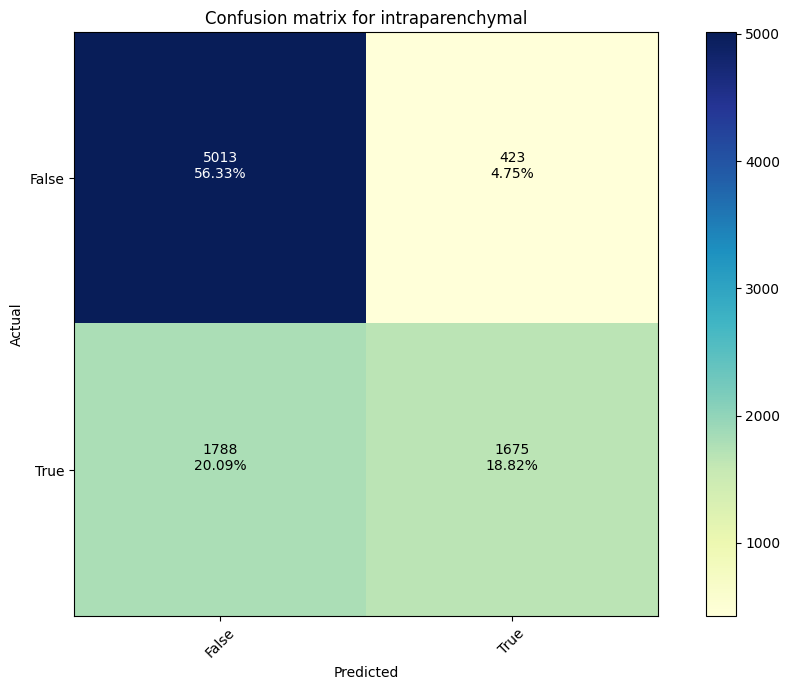

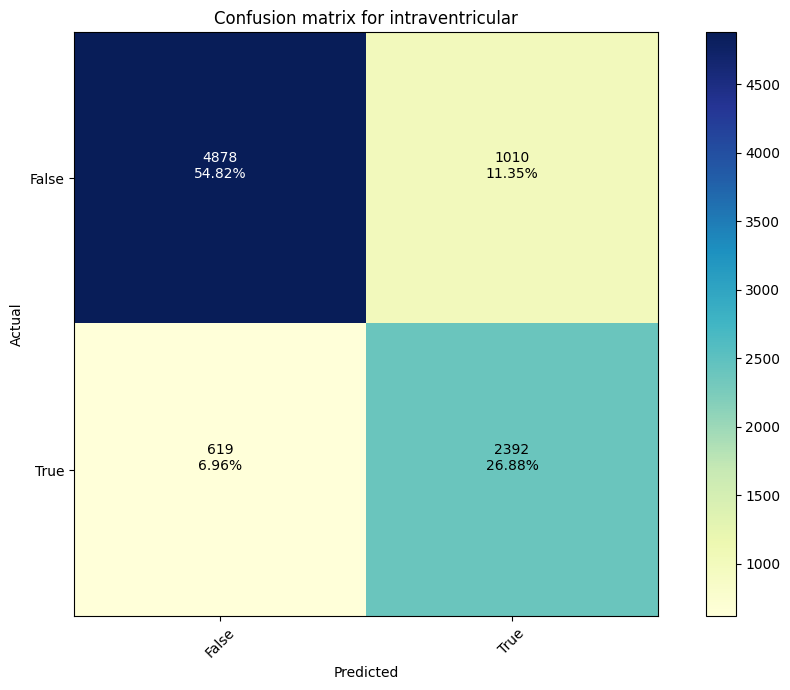

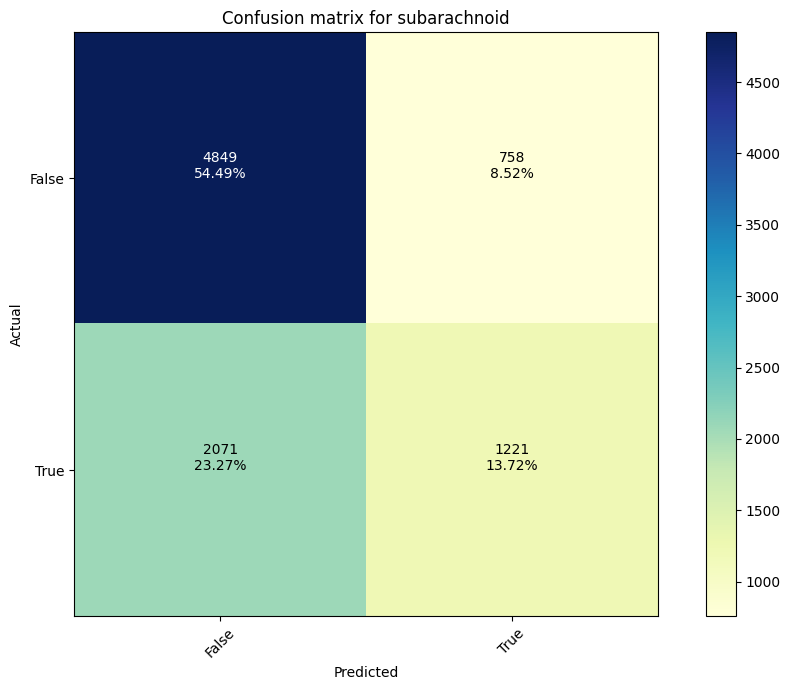

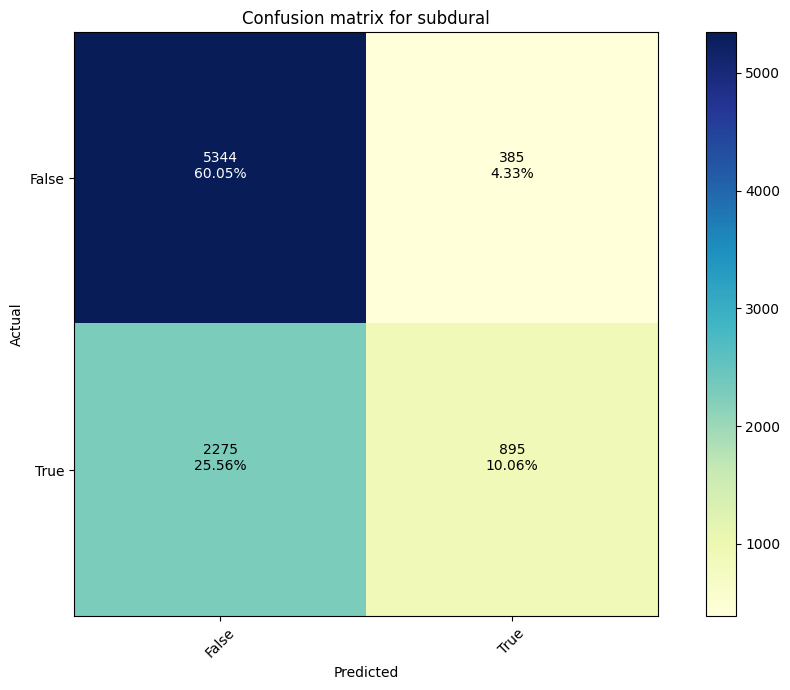

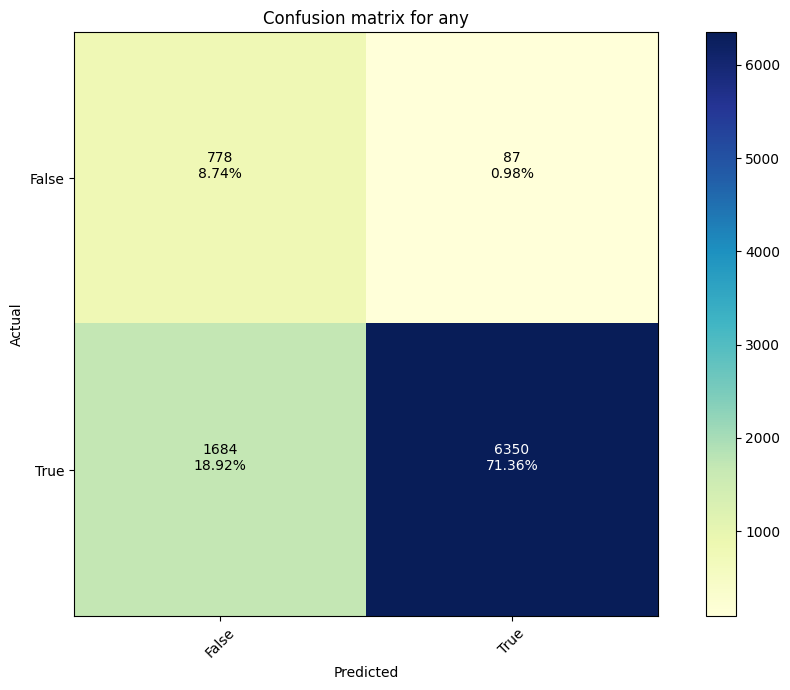

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{title} for {label}")
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}" for value in CLA_label], rotation=45)
    plt.yticks(tick_marks, [f"{value}" for value in CLA_label])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

for idx, cm in enumerate(mcm):
    show_confusion_matrix(mcm[idx], [False, True], labels[idx])



In [195]:

from sklearn.metrics import f1_score, recall_score, precision_score

list_elements = ["accuracy", "precision", "recall", "f1-score"]
for i in range(len(labels)):
    print(f" {labels[i]} \n accuracy:{accuracy_list[i]}\n precision:{precision_list[i]}\n recall:{recall_list[i]}\n f1_score:{f1_score_list[i]}\n")


for elements in ["micro", "macro", "weighted"]:
    f1 = f1_score(y_true, y_pred, average=elements)
    recall = recall_score(y_true, y_pred, average=elements)
    precision = precision_score(y_true, y_pred, average=elements)
    print(f" {elements}\n precision:{precision}\n recall:{recall}\n f1-score:{f1}\n")


 epidural 
 accuracy:0.9749410046072592
 precision:0.23118279569892472
 recall:0.34959349593495936
 f1_score:0.27831715210355984

 intraparenchymal 
 accuracy:0.7515451174289246
 precision:0.7983794089609152
 recall:0.48368466647415537
 f1_score:0.6024096385542169

 intraventricular 
 accuracy:0.8169457242386785
 precision:0.7031158142269254
 recall:0.7944204583194951
 f1_score:0.7459847185404647

 subarachnoid 
 accuracy:0.6820991122598045
 precision:0.616978271854472
 recall:0.37089914945321995
 f1_score:0.46328969834945927

 subdural 
 accuracy:0.7010900101134959
 precision:0.69921875
 recall:0.2823343848580442
 f1_score:0.40224719101123596

 any 
 accuracy:0.8009888751545118
 precision:0.986484387136865
 recall:0.7903908389345282
 f1_score:0.8776173035726625

 micro
 precision:0.8175789884280328
 recall:0.5962167543734889
 f1-score:0.6895681973954765

 macro
 precision:0.6725599046463504
 recall:0.5118871656624004
 f1-score:0.5616442836885999

 weighted
 precision:0.809905493217768